# Goal

# Project Plan

- acquire at least 

In [ ]:


Predict missing values from the data set using clustering
Derive insights on "Armstrong", the person from whom the fitness data was generated
Hypotheses
There are patterns on Armstrong's daily activities.
Armstrong's fitness activity is affected by the month/season of the year.
Data Science Skills Used
Data prep and cleaning
Time Series Analysis
Visualization
Modeling using Parametric Methods
Modeling using the Prophet algorithm
Evaluation of Models

# Data Dictionary

## Summary of Data

In [1]:
# imports
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import requests
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
import os

import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

#import acquire

In [2]:
def basic_clean(data):
    data['target'] = data['readme'].apply(lambda x: x.replace('GitHub is home to over 40 million developers working together to host and review code, manage projects, and build software together.',''))
    data.rename(columns = {'language':'label'}, inplace = True)
    data.drop(columns = ['link', 'readme','Unnamed: 0','index'], inplace = True)
    return data

In [3]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string

def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

def prep_target(df, col):
    #df[col] = df[col].apply(', '.join)
    df = df.assign(original = df[col])
    #df = df['original'].apply(', '.join)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.lemmatized.apply(remove_stopwords))
    #df.drop(columns=["title"], inplace=True)
    return df

In [4]:
def clean(text):
    "a simple function to prepare text data"
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english") + ["r", "u", "2", "ltgt"]
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
        .lower()
    )
    words = re.sub(r"[^\w\s]", "", text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [5]:
df = pd.read_csv('git.csv')
df.head()

,Unnamed: 0,index,language,link,readme
0,0,0.0,JavaScript,freeCodeCamp/freeCodeCamp,['GitHub is home to over 40 million developers...
1,1,1.0,Rust,996icu/996.ICU,['GitHub is home to over 40 million developers...
2,2,2.0,JavaScript,vuejs/vue,['GitHub is home to over 40 million developers...
3,3,3.0,JavaScript,facebook/react,['GitHub is home to over 40 million developers...
4,4,4.0,C++,tensorflow/tensorflow,['GitHub is home to over 40 million developers...


In [6]:
df.shape

(263, 5)

In [7]:
df = prepare.prep_target(df, 'target')

In [8]:
df.head()

,label,target,original,normalized,stemmed,lemmatized,cleaned
0,JavaScript,"['', '', '\n\n\n', 'freeCodeCamp.org is a frie...","['', '', '\n\n\n', 'freeCodeCamp.org is a frie...",freecodecamp org friendly community where yo...,freecodecamp org friendli commun where you can...,freecodecamp org friendly community where you ...,freecodecamp org friendly community learn code...
1,Rust,"['', 'Please note that there exists NO other o...","['', 'Please note that there exists NO other o...",please note that there exists other official ...,pleas note that there exist other offici accou...,please note that there exists other official a...,please note exists official account app mercha...
2,JavaScript,"['', '', '\n\n\n\n\n\n\n\n\n', ""Vue.js is an M...","['', '', '\n\n\n\n\n\n\n\n\n', ""Vue.js is an M...",vue mit licensed open source project in...,vue mit licens open sourc project independ pro...,vue mit licensed open source project independe...,vue mit licensed open source project independe...
3,JavaScript,"['', 'React is a JavaScript library for buildi...","['', 'React is a JavaScript library for buildi...",react javascript library for building user i...,react javascript librari for build user interf...,react javascript library for building user int...,react javascript library building user interfa...
4,C++,"['', 'TensorFlow is an end-to-end open source ...","['', 'TensorFlow is an end-to-end open source ...",tensorflow end end open source platform nfo...,tensorflow end end open sourc platform nfor ma...,tensorflow end end open source platform nfor m...,tensorflow end end open source platform nfor m...


In [9]:
df = df[['label', 'cleaned']]

In [7]:
pd.concat(
[df.label.value_counts(), df.label.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
JavaScript,61,0.369697
Python,21,0.127273
Java,15,0.090909
C++,14,0.084848
Go,9,0.054545
TypeScript,9,0.054545
C,4,0.024242
Rust,3,0.018182
Vue,3,0.018182
Shell,3,0.018182


In [11]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["cleaned"].apply(tokenizer.tokenize)
df.head()

,label,cleaned,tokens
0,JavaScript,freecodecamp org friendly community learn code...,"[freecodecamp, org, friendly, community, learn..."
1,Rust,please note exists official account app mercha...,"[please, note, exists, official, account, app,..."
2,JavaScript,vue mit licensed open source project independe...,"[vue, mit, licensed, open, source, project, in..."
3,JavaScript,react javascript library building user interfa...,"[react, javascript, library, building, user, i..."
4,C++,tensorflow end end open source platform nfor m...,"[tensorflow, end, end, open, source, platform,..."


In [13]:
all_words = [word for tokens in df["tokens"] for word in tokens]

In [14]:
sentence_lengths = [len(tokens) for tokens in df["tokens"]]

In [15]:
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

106949 words total, with a vocabulary size of 9904
Max sentence length is 10595


**Note:** very skewed: short sentences, and a lot of sentences

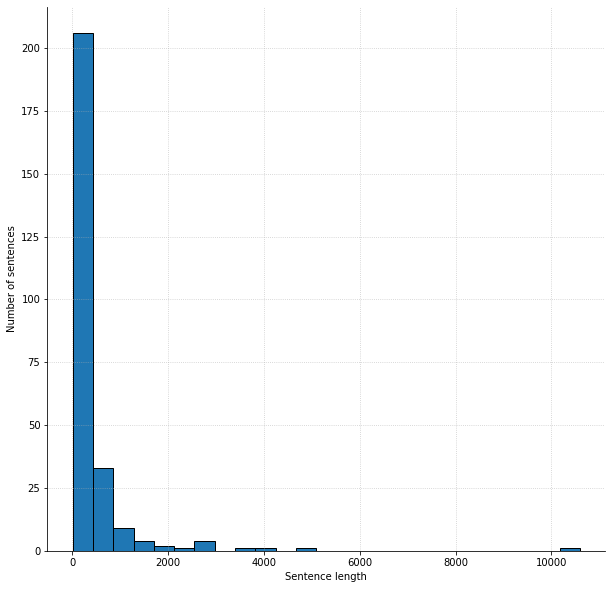

In [22]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

Text(0.5, 1.0, 'Most frequently used programing languages')

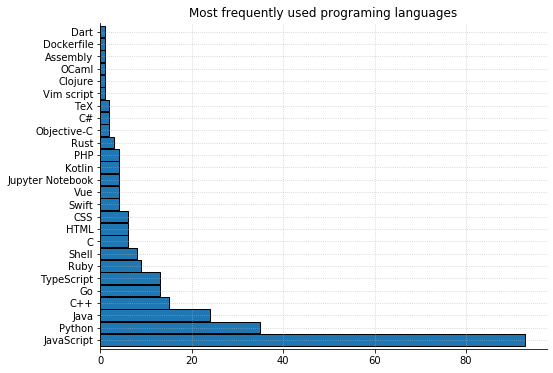

In [41]:
df.label.value_counts().plot.barh(figsize=(8, 6),width = .95)
plt.title('Most frequently used programing languages')

In [ ]:
prep_df_cleaned = " ".join(df.cleaned)
explore_df_cleaned = clean(prep_df_cleaned)

Text(0.5, 1.0, '10 most common words in GitHub Readme.md')

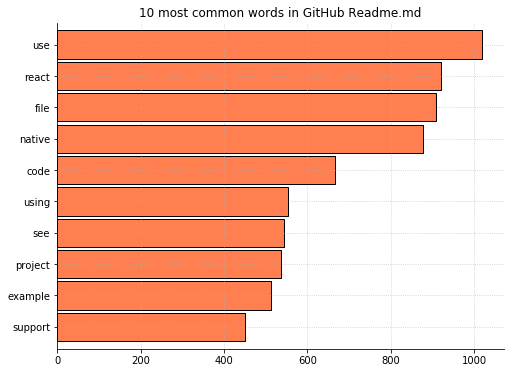

In [51]:
pd.Series(explore_df_cleaned).value_counts().sort_values().tail(10).plot.barh(figsize=(8, 6),width=.9, color = 'coral')
plt.title('10 most common words in GitHub Readme.md')

Text(0.5, 1.0, 'Most frequently seen word combinations in Github Readme.md')

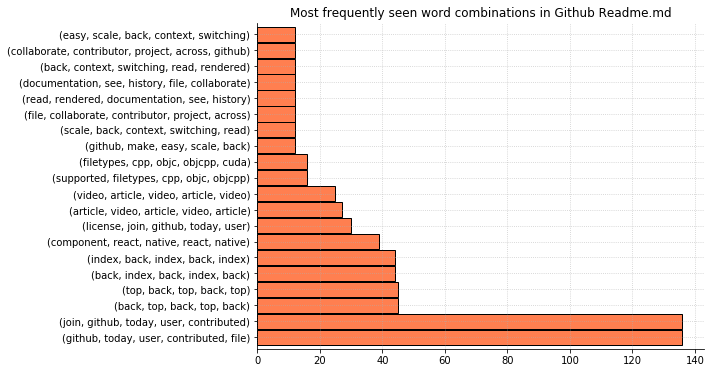

In [102]:
pd.Series(nltk.ngrams(explore_df_cleaned, 5)).value_counts().head(20).plot.barh(figsize=(8, 6), width=.95, color='coral')
plt.title('Most frequently seen word combinations in Github Readme.md')

**Note** Programming language do not appear in readme documents.

In [40]:
print(f"The number of Javascript in dataset: {df[df.cleaned.str.contains('JavaScript')]}")
print(f"The number of Python in dataset: {df[df.cleaned.str.contains('Python')]}")

The number of Javascript in dataset: Empty DataFrame
Columns: [label, cleaned, tokens]
Index: []
The number of Python in dataset: Empty DataFrame
Columns: [label, cleaned, tokens]
Index: []


**Question** Is there any particular wording or sentiment with particular language?

- React is the most commonly used word in project involving JavaScrip
- React is a JavaScript library for building user interfaces, which might be a clue for our model predictions

In [45]:
javascrip_slice = df.copy().drop(columns = 'tokens')
javascrip_slice = javascrip_slice[javascrip_slice.label == 'JavaScript']
prep_java_cleaned = " ".join(javascrip_slice.cleaned)
explore_java_cleaned = clean(prep_java_cleaned)

Text(0.5, 1.0, '20 most common words in GitHub Readme.md using JavaScript as the major language')

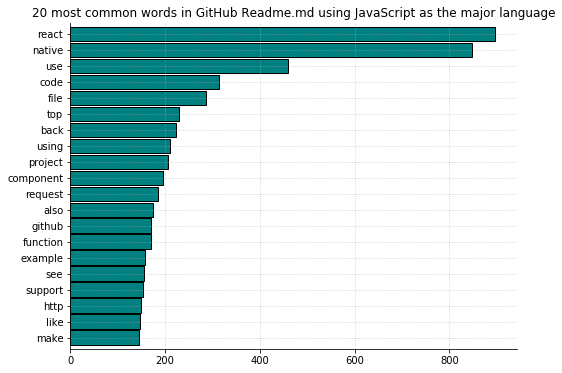

In [52]:
# teal for JavaScript
pd.Series(explore_java_cleaned).value_counts().sort_values().tail(20).plot.barh(figsize=(8, 6),width=.9, color = 'teal')
plt.title('20 most common words in GitHub Readme.md using JavaScript as the major language')

In [53]:
python_slice = df.copy().drop(columns = 'tokens')
python_slice = python_slice[python_slice.label == 'Python']
prep_python_cleaned = " ".join(python_slice.cleaned)
explore_python_cleaned = clean(prep_python_cleaned)

In [ ]:
# teal for JavaScript
pd.Series(explore_python_cleaned).value_counts().sort_values().tail(20).plot.barh(figsize=(8, 6),width=.9, color = 'teal')
plt.title('20 most common words in GitHub Readme.md using Python as the major language')

In [255]:
# string_readme = " ".join(cleaned_df.cleaned) # turn into string for prep
# readme = [string_readme]

In [42]:
df.label.value_counts()

JavaScript          93
Python              35
Java                24
C++                 15
Go                  13
TypeScript          13
Ruby                 9
Shell                8
C                    6
HTML                 6
CSS                  6
Swift                4
Vue                  4
Jupyter Notebook     4
Kotlin               4
PHP                  4
Rust                 3
Objective-C          2
C#                   2
TeX                  2
Vim script           1
Clojure              1
OCaml                1
Assembly             1
Dockerfile           1
Dart                 1
Name: label, dtype: int64

In [43]:
df = df[['label','cleaned']]

In [115]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
df = df.groupby('label').filter(lambda x : len(x)>5)

In [116]:
# version 1
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.label

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [118]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [119]:
lm = LogisticRegression().fit(X_train, y_train)

In [138]:
np.round(lm.coef_, decimals = 2)

array([[-0.  , -0.  , -0.  , ..., -0.01, -0.  , -0.  ],
       [-0.  , -0.  , -0.  , ..., -0.02, -0.  , -0.  ],
       [-0.  , -0.  , -0.  , ..., -0.01, -0.  ,  0.06],
       ...,
       [-0.  , -0.  , -0.  , ..., -0.01, -0.  , -0.  ],
       [-0.  , -0.  , -0.  , ..., -0.01, -0.  , -0.  ],
       [-0.  , -0.  , -0.  , ..., -0.02, -0.  , -0.  ]])

In [137]:
df.label.unique()

array(['JavaScript', 'C++', 'Shell', 'TypeScript', 'Java', 'C', 'Python',
       'Go', 'CSS', 'Ruby', 'HTML'], dtype=object)

In [141]:
from sklearn.feature_selection import RFE
predictors = X_train 
selector = RFE(lm, n_features_to_select = 1) 
selector = selector.fit(predictors, y_train)

KeyboardInterrupt: 

In [ ]:
order = selector.ranking_
order

In [ ]:
feature_ranks = [] 
for i in orders: 
    feature_ranks.append(f"{i}. {dfcol.columns[i]}"

In [120]:
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [121]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))
print('<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 55.49%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  Ruby  Shell  \
predicted                                                                  
C++         0    2    0   0     0     0           0       0     0      0   
Java        0    0    0   0     0     8           0       0     0      0   
JavaScript  3   10    5  10     5     7          71       8     6      6   
Python      2    0    0   0     0     4           3      20     1      1   

actual      TypeScript  
predicted               
C++                  0  
Java                 0  
JavaScript          10  
Python               0  
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
         C++       1.00      0.17      0.29        12
         CSS       0.00      0.00      0.00         5
          Go       0.00      0.00      0.00        10
        HTML       0.00      0.00      0.00         5
        Java       1.00   

/Users/lonilanistea/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# 2nd model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on training set: 0.63
Accuracy of KNN classifier on test set: 0.50


In [52]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

k = knn.fit(X_train, y_train)

In [53]:
train['predicted'] = knn.predict(X_train)
test['predicted'] = knn.predict(X_test)

In [54]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))
print('<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 62.64%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  Ruby  Shell  \
predicted                                                                  
C++         0    3    0   0     1     0           3       0     0      0   
CSS         0    0    4   0     1     1           0       0     0      0   
Go          0    0    0   4     0     0           0       0     1      0   
Java        0    0    0   0     0    10           0       0     0      0   
JavaScript  3    5    0   5     2     2          65       8     3      4   
Python      2    3    1   1     1     5           6      18     1      0   
Ruby        0    0    0   0     0     0           0       0     2      0   
Shell       0    1    0   0     0     0           0       1     0      3   
TypeScript  0    0    0   0     0     1           0       1     0      0   

actual      TypeScript  
predicted               
C++                  0  
CSS                  0  
Go                   0  


/Users/lonilanistea/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier

In [58]:
# clf = CategoricalNB()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_train)
# print('Accuracy of Categorical Naive Bayes classifier on training set: {:.2f}'
#      .format(knn.score(X_train, y_train)))
# print('Accuracy of Categorical Naive Bayes classifier on test set: {:.2f}'
#      .format(knn.score(X_test, y_test)))

In [59]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

In [60]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [61]:
y_pred = clf.predict(X_train)
print('Accuracy of Decision tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision tree classifier on training set: 0.55
Accuracy of Decision tree classifier on test set: 0.50


In [62]:
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)


print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))
print('<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>')
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 54.95%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  Ruby  Shell  \
predicted                                                                  
C++         0    9    0   4     0     4           6       0     0      0   
CSS         0    0    1   0     1     0           0       0     0      0   
Go          0    0    0   4     0     0           0       0     0      0   
JavaScript  4    3    4   2     4    15          67      12     7      7   
Python      1    0    0   0     0     0           1      16     0      0   
TypeScript  0    0    0   0     0     0           0       0     0      0   

actual      TypeScript  
predicted               
C++                  3  
CSS                  0  
Go                   0  
JavaScript           4  
Python               0  
TypeScript           3  
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         5
         C++       0.35      0.75      0

/Users/lonilanistea/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**What if remove names of programming languages from actual readme documents?**

In [71]:
extra_words = ['JavaScript', 'C++', 'Shell', 'TypeScript', 'Java', 'C', 'Python','Go', 'CSS', 'Ruby', 'HTML']

In [65]:
df[df.label == 'JavaScript'].cleaned[0]

'freecodecamp org friendly community learn code free run donor supported nonprofit help million busy adult transition tech community ha already helped people get first developer job full stack web development curriculum completely free self paced thousand interactive coding challenge help expand skill freecodecamp org offer several free developer certification certification involves building required web app project along hundred optional coding challenge help prepare project estimate certification take beginning programmer around hour earn project freecodecamp org curriculum ha agile user story automated test help build project incrementally ensure fulfilled user story submit pull test suite freecodecamp cdn mean build project website like codepen glitch even local computer development environment youve earned certification always always able link linkedin resume prospective employer freelance client click link theyll see verified certification specific one exception discover violatio

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()# use lambda to assign "input" string into vedar for sentiment analysis
# sia.polarity_scores(input) 
vader_title = pd.Series(prep_title).apply(lambda txt: sia.polarity_scores(txt)["compound"])